<a href="https://colab.research.google.com/github/GVSU-CIS635/term-project-proposal-plato/blob/main/CIS635_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Thematic and Argument Structure Analysis of Plato’s Republic Using Data Mining Techniques

Tanishq Daniel, Trevor Ouma, Nate Miller

In [37]:
pip install scikit-learn

In [38]:
import re
import nltk
import string
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tabulate import tabulate
from scipy.stats import entropy
from scipy.stats import spearmanr
from nltk.corpus import stopwords
from urllib.request import urlopen
from gensim.corpora import Dictionary
from nltk.tokenize import word_tokenize
from gensim.models import CoherenceModel
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [39]:
data = urlopen('https://raw.githubusercontent.com/GVSU-CIS635/Datasets/refs/heads/master/republic.txt')
html_response = data.read()
encoding = data.headers.get_content_charset('utf-8')
text_data = html_response.decode(encoding)

In [40]:
# Preprocessing

def extract_text_in_range(text, start_phrase, end_phrase):
  start_index = text_data.find(start_phrase)
  end_index = text_data.find(end_phrase)
  data = text_data[start_index:end_index]
  return data

def preprocess_by_books(text_data, chunk_size, remove_stop_words):
    # Split text by books
    books = re.split(r'BOOK [IVXLCDM]+\.', text_data)
    books = [book.strip() for book in books if book.strip()]
    book_titles = re.findall(r'BOOK [IVXLCDM]+', text_data)
    book_data = {}

    # Process each book
    for title, content in zip(book_titles, books):
        words = nltk.word_tokenize(content)

        # Chunk text before stopword removal
        chunks = [
            ' '.join(words[i:i + chunk_size])
            for i in range(0, len(words), chunk_size)
        ]

        if remove_stop_words:
            # Remove stopwords and punctuation after chunking
            stop_words = stopwords.words('english') + ['said', 'yes', 'true', 'good', 'replied', 'would', 'may', 'us', 'well', "one", "also", "mean", "must", "shall", "certainly", 'replied', 'glaucon', 'socrates', 'adeimantus', 'polemarchus', 'thrasymachus', 'cephalus',
                                                       'charmides', 'critias', 'alcibiades', 'athens', 'athenian', 'piraeus', 'ariston', 'one', 'two', 'three', "like", "many", "another", "man", "men", "say", "let", "asclepius", "suppose", "style", "drink", "seen"]
            punctuation = set(string.punctuation)

            # Filter words in each chunk
            filtered_chunks = []
            for chunk in chunks:
                filtered_words = [
                    word.lower() for word in nltk.word_tokenize(chunk)
                    if word.lower() not in stop_words and word not in punctuation
                ]
                filtered_chunks.append(' '.join(filtered_words))
            chunks = filtered_chunks

        # Add processed chunks to book data
        book_data[title] = chunks

    return book_data

In [41]:
# Extract Themes

def extract_themes(
    text_data,
    start_phrase,
    end_phrase,
    chunk_size=350,
    n_components=10,
    top_words=10,
    max_df=0.85,
    min_df=2,
    random_state=50
):
    text_data = extract_text_in_range(text_data, start_phrase, end_phrase)

    books = preprocess_by_books(text_data, chunk_size, True)
    all_chunks = [chunk for book_chunks in books.values() for chunk in book_chunks]

    vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, stop_words='english')
    term_matrix = vectorizer.fit_transform(all_chunks)
    lda = LatentDirichletAllocation(n_components=n_components, random_state=random_state)
    lda.fit(term_matrix)

    terms = vectorizer.get_feature_names_out()
    themes = [
        [terms[i] for i in theme.argsort()[:-top_words - 1:-1]]
        for theme in lda.components_
    ]

    print("Extracted Themes:")
    for idx, theme in enumerate(themes):
        print(f"Theme {idx + 1}: {' '.join(theme)}")

    chunk_theme_strengths = lda.transform(term_matrix)

    return books, themes, chunk_theme_strengths

In [42]:
def calculate_theme_complexity(themes, theme_aggregates):
    theme_results = []
    for theme_name, values in theme_aggregates.items():
        if values["Count"] > 0:
            avg_complexity = values["Complexity"] / values["Count"]
        else:
            avg_complexity = 0
        theme_results.append({
            "Theme": theme_name,
            "Complexity": avg_complexity,
            "Top Words": ", ".join(themes[int(theme_name.split()[-1]) - 1])
        })

    theme_df = pd.DataFrame(theme_results)
    return theme_df

In [43]:
def calculate_theme_aggregates(chunk_theme_strengths, threshold=0.1):
    theme_aggregates = {}
    for theme_idx in range(chunk_theme_strengths.shape[1]):
        strengths = chunk_theme_strengths[:, theme_idx]
        presence_count = (strengths > threshold).sum()
        total_strength = strengths.sum()
        entropy_score = entropy(strengths / strengths.sum()) if strengths.sum() > 0 else 0

        theme_aggregates[f"Theme {theme_idx + 1}"] = {
            "Total Strength": total_strength,
            "Presence Count": presence_count,
            "Entropy": entropy_score
        }
    return theme_aggregates

def calculate_theme_complexities(theme_aggregates, themes):
    theme_complexities = []
    for theme_name, values in theme_aggregates.items():
        complexity = (
            0.5 * values["Total Strength"] +
            0.3 * values["Presence Count"] +
            0.2 * values["Entropy"]
        )
        theme_complexities.append({
            "Theme": theme_name,
            "Complexity": complexity,
            "Top Words": ", ".join(themes[int(theme_name.split()[-1]) - 1])
        })
    return pd.DataFrame(theme_complexities)

def calculate_theme_complexity_in_chunks(chunk_theme_strengths, themes, theme_complexities, books, threshold, weights):

    # Normalize weights to sum to 1
    total_weight = sum(weights.values())
    weights = {key: value / total_weight for key, value in weights.items()}

    chunk_results = []
    chunk_index = 0

    for book_title, chunks in books.items():
        for chunk_idx, strengths in enumerate(chunk_theme_strengths[chunk_index:chunk_index + len(chunks)]):
            # Calculate raw scores
            presence_score = (strengths > threshold).sum()
            diversity_score = len(strengths[strengths > threshold])
            entropy_score = entropy(strengths / strengths.sum()) if strengths.sum() > 0 else 0
            weighted_contribution = sum(
                strengths[i] * theme_complexities.iloc[i]["Complexity"]
                for i in range(len(themes))
            )

            top_theme_idx = strengths.argmax()
            top_theme = f"Theme {top_theme_idx + 1}"

            # Append raw scores
            chunk_results.append({
                "Book": book_title,
                "Chunk": chunk_idx + 1,
                "Presence Score": presence_score,
                "Diversity Score": diversity_score,
                "Entropy Score": entropy_score,
                "Weighted Contribution": weighted_contribution,
                "Top Theme": top_theme
            })

        chunk_index += len(chunks)

    chunk_df = pd.DataFrame(chunk_results)

    # Apply Z-score normalization
    scaler = StandardScaler()
    normalized_columns = ["Presence Score", "Diversity Score", "Entropy Score", "Weighted Contribution"]
    for column in normalized_columns:
        chunk_df[f"Normalized {column}"] = scaler.fit_transform(chunk_df[[column]])

    # Composite complexity calculation using normalized scores
    chunk_df["Composite Complexity"] = (
        weights["presence"] * chunk_df["Normalized Presence Score"] +
        weights["diversity"] * chunk_df["Normalized Diversity Score"] +
        weights["entropy"] * chunk_df["Normalized Entropy Score"] +
        weights["theme_complexity"] * chunk_df["Normalized Weighted Contribution"]
    )

    scaler = MinMaxScaler()
    chunk_df["Normalized Complexity"] = scaler.fit_transform(chunk_df[["Composite Complexity"]])

    return chunk_df


In [44]:
# Theme Complexity
def calculate_theme_complexity(books, themes, chunk_theme_strengths, threshold, weights):

    theme_aggregates = calculate_theme_aggregates(chunk_theme_strengths, threshold)

    themes_df = calculate_theme_complexities(theme_aggregates, themes)

    chunk_themes = calculate_theme_complexity_in_chunks(
        books=books,
        themes=themes,
        chunk_theme_strengths=chunk_theme_strengths,
        theme_complexities=themes_df,
        threshold=threshold,
        weights=weights
    )

    return themes_df, chunk_themes



In [45]:
# Argument Extraction

def extract_arguments(text_data, chunk_size, start_phrase, end_phrase):
    start_index = text_data.find(start_phrase)
    end_index = text_data.find(end_phrase)
    text_data = text_data[start_index:end_index]

    books = preprocess_by_books(text_data, chunk_size, False)

    argument_markers = [
        r"\btherefore\b", r"\bbecause\b", r"\bif\b.*?\bthen\b", r"\bthus\b", r"\bas a result\b",
        r"\bhence\b", r"\bconsequently\b", r"\bimplies\b", r"\bin conclusion\b", r"\bdue to\b",
        r"\bprovided that\b", r"\balthough\b", r"\bdespite\b", r"\bnevertheless\b", r"\bwe conclude that\b",
        r"\bon the condition that\b", r"\bit follows that\b"
    ]
    argument_pattern = re.compile("|".join(argument_markers), re.IGNORECASE)

    arguments = []

    for book_title, chunks in books.items():
        for chunk_idx, chunk in enumerate(chunks):
            sentences = nltk.sent_tokenize(chunk)
            for sentence in sentences:
                if argument_pattern.search(sentence):
                    arguments.append({
                        "Book": book_title,
                        "Chunk": chunk_idx + 1,
                        "Argument": sentence
                    })

    arguments_df = pd.DataFrame(arguments)
    return arguments_df


In [46]:
# Argument Complexity
def calculate_argument_complexity(arguments_df):

    complexity_data = []

    argument_markers = [
        r"\btherefore\b", r"\bbecause\b", r"\bif\b.*?\bthen\b", r"\bthus\b", r"\bas a result\b",
        r"\bhence\b", r"\bconsequently\b", r"\bimplies\b", r"\bin conclusion\b"
    ]
    connectives_pattern = re.compile("|".join(argument_markers), re.IGNORECASE)

    for _, row in arguments_df.iterrows():
        argument = row["Argument"]
        word_count = len(nltk.word_tokenize(argument))
        logical_connectives = len(re.findall(connectives_pattern, argument))
        avg_word_length = sum(len(word) for word in nltk.word_tokenize(argument)) / word_count
        argument_type = "conditional" if re.search(r"\bif\b.*?\bthen\b", argument, re.IGNORECASE) else "general"

        complexity_data.append({
            "Book": row["Book"],
            "Chunk": row["Chunk"],
            "Argument": argument,
            "Word Count": word_count,
            "Logical Connectives": logical_connectives,
            "Average Word Length": avg_word_length,
            "Argument Type": argument_type
        })

    complexity_df = pd.DataFrame(complexity_data)

    # Normalize metrics
    scaler = MinMaxScaler()
    for column in ["Word Count", "Logical Connectives", "Average Word Length"]:
        complexity_df[f"Normalized {column}"] = scaler.fit_transform(complexity_df[[column]])

    # Calculate composite complexity
    complexity_df["Argument Complexity"] = (
        complexity_df["Normalized Word Count"] * 0.4 +
        complexity_df["Normalized Logical Connectives"] * 0.4 +
        complexity_df["Normalized Average Word Length"] * 0.2
    )

    return complexity_df

In [47]:
# Spearman's Correlation using scipy

def calculate_spearman_correlation_table(theme_df, argument_df):

    # Merged dataframes on Book and Chunk
    merged_df = pd.merge(theme_df, argument_df, on=["Book", "Chunk"], how="inner")

    # Normalized complexities
    theme_complexity = merged_df["Normalized Complexity"].values
    argument_complexity = merged_df["Argument Complexity"].values

    # Spearman's correlation
    correlation, p_value = spearmanr(theme_complexity, argument_complexity)

    # Results table
    corr_metrics_df = pd.DataFrame({
        'Metric': ["Correlation", "P-value"],
        'Value': [correlation, p_value]
    })

    # Print correlation table
    print("\nSpearman's Correlation Results using scipy:\n")
    display(corr_metrics_df)

    return correlation, p_value

In [48]:
# Spearman's Correlation using sklearn and numpy

def calculate_spearman_with_sklearn(theme_df, argument_df):

    # Dataframes on Book and Chunk
    merged_df = pd.merge(theme_df, argument_df, on=["Book", "Chunk"], how="inner")

    # Normalized complexities
    theme_complexity = merged_df["Normalized Complexity"].values
    argument_complexity = merged_df["Argument Complexity"].values

    # Rank data
    theme_ranks = LabelEncoder().fit_transform(theme_complexity)
    argument_ranks = LabelEncoder().fit_transform(argument_complexity)

    # Pearson correlation on ranks
    correlation = np.corrcoef(theme_ranks, argument_ranks)[0, 1]

    # Results table
    sklearn_results_df = pd.DataFrame({
        'Metric': ["Correlation"],
        'Value': [correlation]
    })

    # Print correlation table
    print("\nSpearman's Correlation Results using sklearn:\n")
    display(sklearn_results_df)

    return correlation

In [49]:
# Perform Linear Regression

def perform_regression(theme_df, argument_df):
    merged_df = pd.merge(theme_df, argument_df, on=["Book", "Chunk"], how="inner")

    merged_df.to_csv('regression_merge.csv', index=False)

    if merged_df.empty:
        raise ValueError("Merged DataFrame is empty. Check data alignment between themes and arguments.")

    X = merged_df[["Normalized Complexity"]].values
    y = merged_df["Argument Complexity"].values

    reg = LinearRegression()
    reg.fit(X, y)
    predictions = reg.predict(X)

    return {
        "Intercept": reg.intercept_,
        "Slope": reg.coef_[0],
        "R^2 Score": reg.score(X, y),
        "X": X,
        "y": y,
        "Predictions": predictions
    }


In [50]:
def polynomial_regression(theme_df, argument_df,  degree=2):
  merged_df = pd.merge(theme_df, argument_df, on=["Book", "Chunk"], how="inner")

  X = merged_df[["Normalized Complexity"]].values
  y = merged_df["Argument Complexity"].values

  polynomial_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
  polynomial_model.fit(X, y)
  y_pred = polynomial_model.predict(X)

  # Calculate regression metrics
  r2 = r2_score(y, y_pred)
  mse = mean_squared_error(y, y_pred)

  # Cross-validation
  cv_scores = cross_val_score(polynomial_model, X, y, cv=5, scoring="r2")
  mean_cv_r2 = np.mean(cv_scores)

  # Create a DataFrame for the results
  results_df = pd.DataFrame({
      'Metric': ["R² Score", "Mean Squared Error", "Mean R² (CV)"],
      'Value': [f"{r2:.3f}", f"{mse:.3f}", f"{mean_cv_r2:.3f}"]
  })

    # Print the results table
  print("\nRegression Analysis Results:")
  print(results_df)

  # Plot scatter and polynomial regression line
  plt.figure(figsize=(10, 6))
  plt.scatter(X, y, c=np.abs(y - y_pred), cmap="coolwarm", label="Actual Data")
  plt.plot(X, y_pred, color="red", label="Polynomial Fit (Degree 2)")
  plt.fill_between(X.flatten(), y_pred - 1.96 * np.std(y - y_pred), y_pred + 1.96 * np.std(y - y_pred), color='gray', alpha=0.2, label="95% Confidence Interval")
  plt.xlabel("Theme Complexity Score")
  plt.ylabel("Argument Complexity")
  plt.title(f"Polynomial Regression (Degree {degree}): Theme vs. Argument Complexity")
  plt.colorbar(label="Prediction Error")
  plt.legend()
  plt.show()

  return polynomial_model

In [51]:
def linear_regression_visualization(regression_results, chunk_themes, themes):
    # Linear graph
    X = regression_results["X"]
    y = regression_results["y"]
    predictions = regression_results["Predictions"]

    plt.scatter(X, y, label="Actual Data")
    plt.plot(X, predictions, color="red", label="Regression Line")
    plt.xlabel("Theme Complexity Score")
    plt.ylabel("Argument Complexity")
    plt.title("Linear Regression: Theme vs. Argument Complexity")
    plt.legend()
    plt.show()

    top_theme_counts = chunk_themes["Top Theme"].value_counts()
    print()
    # Theme pie chart
    top_theme_percentages = top_theme_counts / top_theme_counts.sum() * 100
    theme_indices = [
        int(theme.split(" ")[1]) - 1 for theme in top_theme_percentages.index
    ]
    theme_labels = [
        f"Theme {i + 1}: {', '.join(themes[i][:3]) if len(themes[i]) >= 3 else ', '.join(themes[i])}"
        for i in theme_indices
    ]
    plt.figure(figsize=(10, 8))
    plt.pie(top_theme_percentages, labels=theme_labels, autopct='%1.1f%%', startangle=140)
    plt.title("Percentage of Each Theme as Top Theme in Chunks")
    plt.axis('equal')
    plt.show()

def polynomial_regression_visualization(visualization_data, degree=2):
    X = visualization_data["X"]
    y = visualization_data["y"]
    y_pred = visualization_data["y_pred"]
    prediction_error = visualization_data["prediction_error"]
    confidence_interval = visualization_data["confidence_interval"]

    # Scatter plot with polynomial regression line
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X, y, c=prediction_error, cmap="coolwarm", label="Actual Data")
    plt.plot(X, y_pred, color="red", label=f"Polynomial Fit (Degree {degree})")
    plt.fill_between(X, y_pred - confidence_interval, y_pred + confidence_interval, color="gray", alpha=0.2, label="95% Confidence Interval")
    plt.colorbar(scatter, label="Prediction Error")
    plt.xlabel("Theme Complexity Score")
    plt.ylabel("Argument Complexity")
    plt.title(f"Polynomial Regression (Degree {degree}): Theme vs. Argument Complexity")
    plt.legend()
    plt.show()

    # Display regression metrics
    print("\nRegression Metrics:")
    print(f"R² Score: {visualization_data['r2']:.3f}")
    print(f"Mean Squared Error: {visualization_data['mse']:.3f}")
    print(f"Mean R² (Cross-Validation): {visualization_data['mean_cv_r2']:.3f}")

In [52]:
# Cross validation for LDA

data = urlopen('https://raw.githubusercontent.com/GVSU-CIS635/Datasets/refs/heads/master/republic.txt')
html_response = data.read()
encoding = data.headers.get_content_charset('utf-8')
text_data = html_response.decode(encoding)

def evaluate_theme_alignment(model, vectorizer, expected_themes, terms_per_theme=10):
    feature_names = vectorizer.get_feature_names_out()
    themes = model.components_
    evaluation_results = {}

    for theme_idx, theme in enumerate(themes):
        top_term_indices = theme.argsort()[:-terms_per_theme - 1:-1]
        top_terms = [feature_names[i] for i in top_term_indices]

        score = 0
        theme_matches = {}
        for theme, keywords in expected_themes.items():
            matches = set(top_terms).intersection(keywords)
            if matches:
                theme_matches[theme] = list(matches)
                score += len(matches)

        evaluation_results[f"theme {theme_idx}"] = {
            "top_terms": top_terms,
            "score": score,
            "theme_matches": theme_matches
        }

    return dict(sorted(evaluation_results.items(), key=lambda item: item[1]['score'], reverse=True))

def calculate_coherence(processed_text, n_components, vectorizer):
    tokenized_docs = [doc.split() for doc in processed_text]
    dictionary = Dictionary(tokenized_docs)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]
    lda_gensim = gensim.models.LdaModel(corpus=corpus, num_topics=n_components, id2word=dictionary, passes=15)
    coherence_model = CoherenceModel(model=lda_gensim, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score

def extract_themes_and_evaluate(text, chunk_size_list, n_components_list, number_top_words, max_df, min_df, seed, expected_themes):
    best_coherence = -1
    best_coherence_params = None
    best_coherence_themes = None
    best_alignment = -1
    best_alignment_params = None
    best_alignment_themes = None

    for chunk_size in chunk_size_list:
        for n_components in n_components_list:
            for top_words in number_top_words:
                for max in max_df:
                  for min in min_df:
                    print(f"\nProcessing with chunk_size={chunk_size}, n_components={n_components}, top_words={top_words}, max_df={max}, min_df={min}")
                    books = preprocess_by_books(text, chunk_size, True)
                    chunks = [chunk for book_chunks in books.values() for chunk in book_chunks]

                    vectorizer = CountVectorizer(max_df=max, min_df=min, stop_words=stopwords.words('english'), ngram_range=(1, 2))
                    term_matrix = vectorizer.fit_transform(chunks)

                    lda = LatentDirichletAllocation(n_components=n_components, random_state=seed)
                    lda.fit(term_matrix)

                    terms = vectorizer.get_feature_names_out()
                    themes = [" ".join([terms[i] for i in theme.argsort()[:-10 - 1:-1]]) for theme in lda.components_]
                    coherence = calculate_coherence(chunks, n_components, vectorizer)
                    print("themes:")
                    for theme in themes:
                        print(theme)
                    print(f"Coherence Score: {coherence}")
                    theme_alignment = evaluate_theme_alignment(lda, vectorizer, expected_themes, terms_per_theme=10)
                    alignment_score = 0
                    print("\ntheme Alignment Evaluation:")
                    for theme, data in theme_alignment.items():
                        print(f"{theme}: Score = {data['score']}, Matches = {data['theme_matches']}")
                        alignment_score += data['score']

                    if coherence > best_coherence:
                        best_coherence = coherence
                        best_coherence_params = (chunk_size, n_components, max, min)
                        best_coherence_themes = themes


                    if alignment_score > best_alignment:
                        best_alignment = alignment_score
                        best_alignment_params = (chunk_size, n_components, max, min)
                        best_alignment_themes = themes

                theme_alignment = evaluate_theme_alignment(lda, vectorizer, expected_themes, terms_per_theme=10)


    if best_coherence_themes:
        print("\nBest Coherence Score:", best_coherence_themes)
        print("Best Parameters (chunk_size, n_components):", best_coherence_params)
        print("\nBest Coherence themes:")
        for theme in best_coherence_themes:
            print(theme)
    else:
        print("No valid coherence themes found. Please check preprocessing or parameters.")

    if best_alignment_themes:
        print("\nBest Alignment Score:", best_alignment_themes)
        print("Best Parameters (chunk_size, n_components):", best_alignment_params)
        print("\nBest Alignment themes:")
        for theme in best_alignment_themes:
            print(theme)
    else:
        print("No valid coherence themes found. Please check preprocessing or parameters.")

# Based on manual reading of the text
expected_themes = {
    "Justice": ["justice", "injustice", "virtue", "morality", "ethics", "fairness"],
    "Ideal State": ["city", "state", "ruler", "hierarchy", "class", "governance"],
    "Philosopher-King": ["philosopher", "wisdom", "knowledge", "truth", "enlightenment", "learning"],
    "The Forms": ["form", "idea", "ideal", "reality", "appearance", "perception"],
    "Tripartite Soul": ["reason", "spirit", "desire", "appetite", "rationality", "pleasure"],
    "Justice in the Soul and State": ["harmony", "balance", "order", "structure", "unity", "justice"],
    "Education and Censorship": ["education", "music", "poetry", "censorship", "youth", "virtue"],
    "Allegory and Myth": ["cave", "allegory", "shadows", "sun", "ignorance", "vision"],
    "Democracy": ["democracy", "tyranny", "freedom", "lawlessness", "corruption", "power"],
    "Metaphysics and Epistemology": ["reality", "knowledge", "belief", "opinion", "truth", "perception"],
}

# Settled on these parameters considering output and manual examination
# To evaluate other options add values to the arrays
chunk_size_list = [350]
n_components_list = [15]
top_words = [10]
max_df = [.85]
min_df = [2]

extract_themes_and_evaluate(text_data, chunk_size_list, n_components_list, top_words, max_df, min_df, seed=40, expected_themes=expected_themes)


Processing with chunk_size=350, n_components=15, top_words=10, max_df=0.85, min_df=2
themes:
state soul whether truth knowledge reason first nature life know
state see think lie way soul things know sort make
justice nature better state philosophy knowledge temperance best opinion see
soul see sight far reason body sun pleasure neither natural
justice injustice life whether knowledge unjust virtue republic think state
interest justice art right stronger answer made way make state
plato state great way knowledge modern might first human truth
state plato laws nature whether first republic human still life
state women way life woman power upon son plato finger
evil slaves fear think either state truth understand first city
opinion knowledge state things soul nature neither god know subject
plato state knowledge world greek life idea god city human
life state first property nature whether knowledge place better mind
state desires soul desire mind world things plato knowledge sense
state 

Extracted Themes:
Theme 1: state knowledge real virtue things wise existence truth pleasure master
Theme 2: opinion soul know knowledge state nature way desire thing time
Theme 3: best state way life evil soul great place truth time
Theme 4: bed opinion people maker understand class state pleasure tyrant 100
Theme 5: evil life nature soul unjust wise gods things great desire
Theme 6: state pleasure rulers nature great city think way pain life
Theme 7: knowledge know great life father sort justice mind state able
Theme 8: state gods life guardians truth better way soul city make
Theme 9: right truth knowledge things ought saying state make bad evil
Theme 10: state justice nature answer question guardians knowledge truth evil know
Theme 11: light sight sun shadows soul able life world eyes eye
Theme 12: state time music old things sort women knowledge tell way
Theme 13: state tyrant mind unjust life city nature justice things words
Theme 14: justice injustice art unjust stronger think ma

,Metric,Value
0,Correlation,0.053586
1,P-value,0.307932



Spearman's Correlation Results using sklearn:



,Metric,Value
0,Correlation,0.053881




Regression Analysis Results:
               Metric   Value
0            R² Score   0.005
1  Mean Squared Error   0.013
2        Mean R² (CV)  -0.011


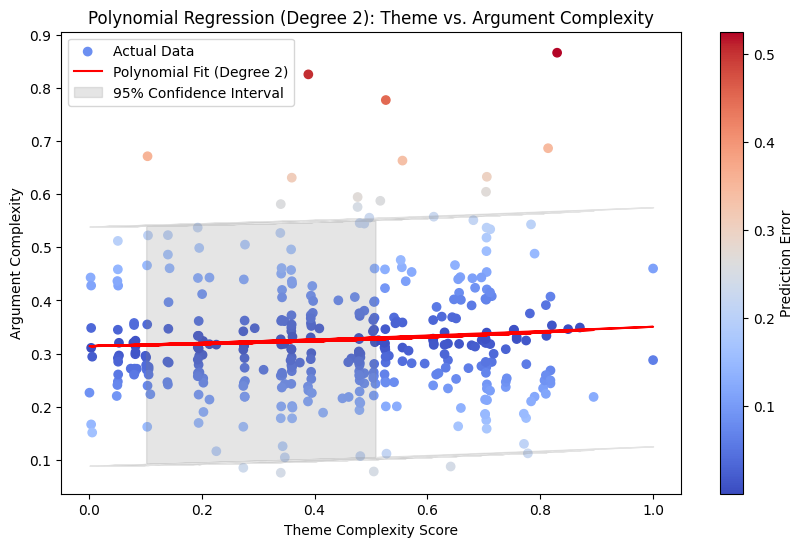

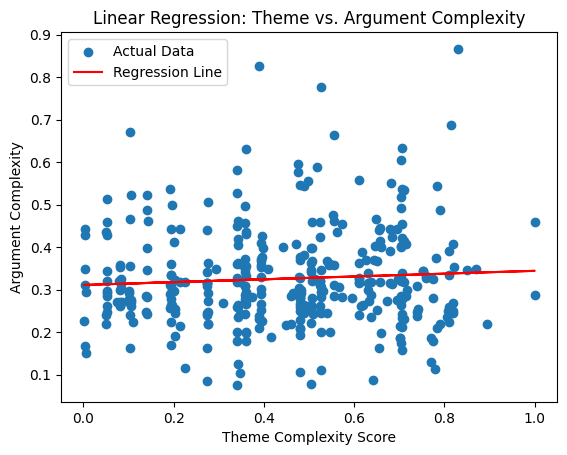

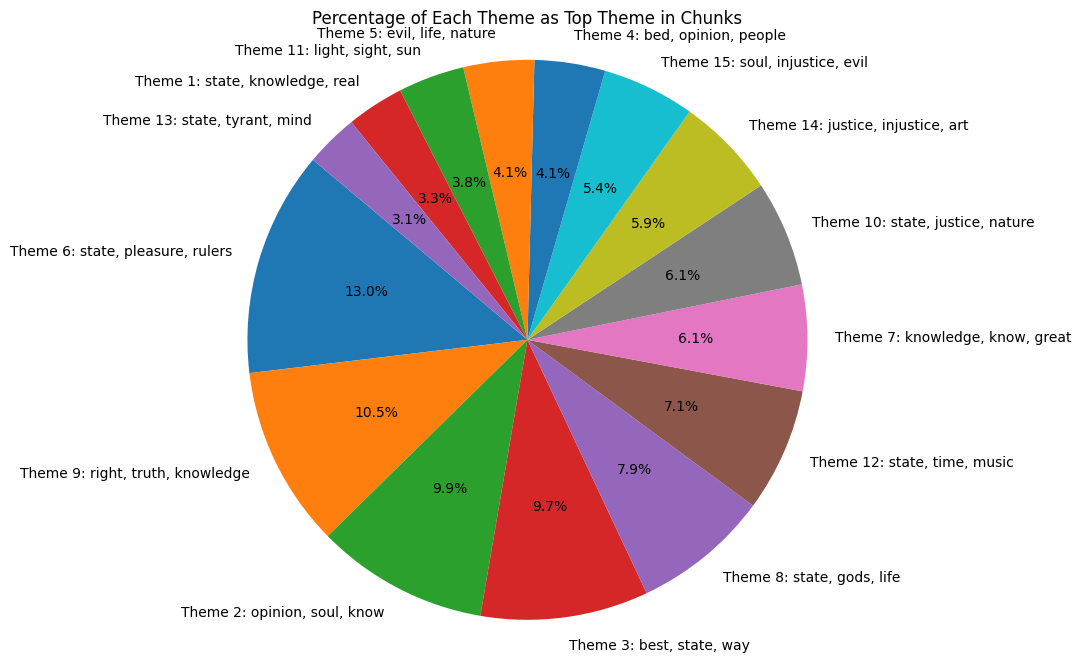

In [53]:
def main():
    data = urlopen('https://raw.githubusercontent.com/GVSU-CIS635/Datasets/refs/heads/master/republic.txt')
    html_response = data.read()
    encoding = data.headers.get_content_charset('utf-8')
    text_data = html_response.decode(encoding)

    start_phrase = "BOOK I.\n\nI went down yesterday to the Piraeus with Glaucon the son of Ariston"
    end_phrase = "End of the Project Gutenberg EBook of The Republic, by Plato"

    chunk_size = 350
    threshold = 0.1
    n_components = 15
    top_words = 10
    max_df = 0.85
    min_df = 2

    theme_weights = {"presence": 0.1, "diversity": 0.1, "entropy": 0.2, "theme_complexity": 0.6}

    # Extract themes and arguments
    books, themes, chunk_theme_strengths = extract_themes(
        text_data=text_data,
        start_phrase=start_phrase,
        end_phrase=end_phrase,
        chunk_size=chunk_size,
        n_components=n_components,
        top_words=top_words,
        max_df=max_df,
        min_df=min_df
    )

    theme_complexity, chunk_themes = calculate_theme_complexity(books, themes, chunk_theme_strengths, threshold=threshold, weights=theme_weights)

    chunk_themes.to_csv('themes_per_chunk.csv', index=False)
    theme_complexity.to_csv('theme_complexity.csv', index=False)

    arguments = extract_arguments(
        text_data=text_data,
        chunk_size=chunk_size,
        start_phrase=start_phrase,
        end_phrase=end_phrase,
    )
    print()
    # Calculate argument complexity
    argument_complexity = calculate_argument_complexity(arguments)

    argument_complexity.to_csv('arguments.csv', index=False)
    print()

    # Calculate Spearman's correlation using scipy
    correlation_scipy, p_value, = calculate_spearman_correlation_table(chunk_themes, argument_complexity)

    # Calculate Spearman's correlation using sklearn-based method
    correlation_sklearn = calculate_spearman_with_sklearn(chunk_themes, argument_complexity)

    # Combine results into a single DataFrame
    combined_correlation_table = pd.DataFrame({
        'Method': ["Scipy (with P-value)", "Sklearn"],
        'Metric': ["Spearman's Correlation", "Spearman's Correlation"],
        'Value': [correlation_scipy, correlation_sklearn],
        'P-value': [p_value, "N/A"]
    })
    # Save to a single CSV file
    combined_correlation_table.to_csv('combined_correlation_table.csv', index=False)

    print()
    # Perform polynominal regrerssion
    polynomial_regression(chunk_themes, argument_complexity, degree=2)

    print()
    # Perform regression analysis
    regression_results = perform_regression(chunk_themes, argument_complexity)

    # Visualize linear regression
    linear_regression_visualization(regression_results, chunk_themes, themes)

main()
